In [0]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
 
with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)
   
sess = tf.Session(config=config)
 
try:
  sess.run(tf.global_variables_initializer())
  print('ok')
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise


W1015 06:11:38.398387 140189325367168 deprecation.py:323] From <ipython-input-1-5d5135f72728>:7: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1015 06:11:38.407418 140189325367168 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/layers/convolutional.py:424: apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


ok


To run the code in this Python notebook, it is required to mount your google drive and then create a folder called WheresWally in your My Drive.

In [0]:
from os.path import join
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd /content/gdrive/My Drive/WheresWally

/content/gdrive/My Drive/WheresWally


# 1. Introduction

Computer vision is a rapidly expanding area of study within the field of Computer Science. One of the many issues that this domain tries to address in regard to the ‘vision’ aspect is object detection and pattern recognition, with the end-goal of making computers view the world in a similar way to us. This means that an AI must not only be able to ‘see’ an object but must also be able to understand the contents of the image.


To recap our project proposal:

The article which we based our project on is 'How to Find Wally with a Neural Network'. This study applied a neural network to the classic image segmentation problem of finding Wally. Finding Wally presented an interesting challenge (as predicted) because Wally varies in size from image to image and has repeating patterns of different significance. In addition, some images have Wally partially obscured, therefore occlusion had to be accounted for. This notebook details a method to train a model using an RCNN to detect Wally in the game "Where's Wally".


## 1.1 Objective


Our first objective was creating a neural network capable of consistently detecting Wally's location. This was accomplished through the use of Tensorflow’s Object Detection API with the help of transfer learning.

Our second objective was also to track the effectiveness of the system that we’ve developed, to assess how well we expect it to perform, potentially giving us some clues on future improvements.

The third objective was to come up with a variety of practical uses for this system, since having a model that’s only ever able to detect Wally would not contribute to the field of Computer Vision in any meaningful way. However, the system can be re-trained, if we were to pursue future development, hence allowing the application of this neural network to be expanded beyond its original scope.


## 1.2 Background Information

* RCNN: Region-based Convolutional Neural Network, the main model used during development.
* Transfer learning: Increasing learning speed by introducing a pre-trained model to improve upon, this was taken from the work done in the original article which was the basis for our project.
* Hey-Waldo repository: ~6500 ‘.jpg’ image entries, black & white + colour, divided into training/testing as needed.
* COCO dataset: COCO or Common Objects in Context, is a large image dataset designed for object detection, segmentation and caption generation. The package provided us with a Python API that assisted in loading, parsing, and visualizing the annotations in COCO.


## 1.3 A note on the COCO dataset

* The dataset provides useful annotations for teaching AI to distinguish objects, since we as humans can do it with ease, using this pre-made data would allow for faster and more efficient training in supervised and semi-supervised modes of neural network development.
* Even the smaller details are annotated, which, when used, would allow for a higher degree of accuracy, because an AI would have a greater awareness of the variety of objects thus increasing the likelihood of a correct classification, versus leaving an object unannotated, introducing the possibility of it being mislabelled - we take advantage of this fact to clearly classify things that aren't Wally, while also bolstering the algorithm's understanding of what 'Wally' is.

# 2. Neural Network

In [0]:
%matplotlib inline

  
from matplotlib import pyplot as plt
import numpy as np
import skimage.io as io
import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.patches as patches
import argparse
import sys


## 2.1 Preparing the Dataset

It is important that before attempting to produce a neural network, the training data is formatted and prepared. This is an extremely important process necessary for deep learning. The training data consist of images and a set of locations that define where the desired object is located. Bounding boxes are then created around these objects to show their location.

Since Tensorflow requires a set of pre-labelled images, it was necessary to find a set of training data that consisted of Where's Wally images along with Wally's location. In the referenced study, an already solved training data set was found on a GITHUB repository known as Hey-Waldo. The data set is as follow:


In [0]:
from google.colab import files

In [0]:
waldotable = pd.read_csv('annotations.csv')
waldotable.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1.jpg,2048,1251,waldo,706,513,743,562
1,10.jpg,1600,980,waldo,715,157,733,181
2,11.jpg,2828,1828,waldo,460,1530,482,1557
3,12.jpg,1276,1754,waldo,846,517,878,563
4,13.jpg,1280,864,waldo,932,274,942,288


The .csv file above is then packed alongside our images into a single binary .tfrecord file for TensorFlow.  One of which is for training the model - train.tfrecord; whilst the other is to evaluate the accuracy of the model itself - test.tfrecord.

## 2.2 Preparing the Model

Clone the Tensorflow Model Repository.

In [0]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


Clone the COCO Object Detection API. This will only be necessary for the evaluation process, but its simpler to just clone the entire repository.

In [0]:
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 10.12 MiB/s, done.
Resolving deltas: 100% (570/570), done.


In [0]:
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/gdrive/My\ Drive/WheresWally/models/research/

python setup.py build_ext --inplace
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-2.7
creating build/temp.linux-x86_64-2.7/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -fno-strict-aliasing -Wdate-time -D_FORTIFY_SOURCE=2 -g -fdebug-prefix-map=/build/python2.7-MW0004/python2.7-2.7.15=. -fstack-protector-strong -Wformat -Werror=format-security -fPIC -I/usr/local/lib/python2.7/dist-packages/numpy/core/include -I../common -I/usr/include/python2.7 -c ../common/maskApi.c -o build/temp.linux-x86_64-2.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
       ^~~
../common/maskApi.c:46:49: note: ...th

Set the environment for all operations following the next.

In [0]:
%cd /content/gdrive/My Drive/WheresWally/models/research/

/content/gdrive/My Drive/WheresWally/models/research


Note that the checkpoint files will be going into the new train directory created below and the frozeninferencegraph.pb file will be going into the evall directory.

In [0]:
!mkdir train evall
%set_env PYTHONPATH=/content/gdrive/My Drive/WheresWally/models/research:/content/gdrive/My Drive/WheresWally/models/research/slim

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘evall’: File exists
env: PYTHONPATH=/content/gdrive/My Drive/WheresWally/models/research:/content/gdrive/My Drive/WheresWally/models/research/slim


Compile the model definitions.

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

The following command is executed to test if the object detection API is working as intended.

In [0]:
!python object_detection/builders/model_builder_test.py

W1015 06:14:42.270392 139752065222528 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1015 06:15:15.922746 139752065222528 module_wrapper.py:139] From /content/gdrive/My Drive/WheresWally/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W1015 06:15:35.715008 139752065222528 module_wrapper.py:139] From /content/gdrive/My Drive/WheresWally/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

Running tests under Python 2.7.15: /usr/bin/python2
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_

Now we have to gets the pre-trained model for transfer learning.

In [0]:
!wget http://storage.googleapis.com/download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_11_06_2017.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_11_06_2017.tar.gz
!cp faster_rcnn_resnet101_coco_11_06_2017/model.ckpt.* .

--2019-10-15 03:17:03--  http://storage.googleapis.com/download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_11_06_2017.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595490113 (568M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_coco_11_06_2017.tar.gz.1’

faster_rcnn_resnet1 100%[===================>] 567.90M  40.3MB/s    in 13s     

2019-10-15 03:17:17 (43.3 MB/s) - ‘faster_rcnn_resnet101_coco_11_06_2017.tar.gz.1’ saved [595490113/595490113]

faster_rcnn_resnet101_coco_11_06_2017/
faster_rcnn_resnet101_coco_11_06_2017/model.ckpt.index
faster_rcnn_resnet101_coco_11_06_2017/model.ckpt.meta
faster_rcnn_resnet101_coco_11_06_2017/frozen_inference_graph.pb
faster_rcnn_resnet101_coco_11_06_2017/model.ckpt.data-00000-of-00001
faster_rcnn_resnet101_coco_11_

As stated above, it would take at least a week to train the model from scratch using the images found on the repository. As opposed to that, we opted to apply transfer learning instead. This would impact the accuracy of detection, but nevertheless greatly reduce the amount of time required for the training process. We took the RCNN with inception V2 model used to train the COCO dataset, as can be seen above and replaced its configuration files. This allowed us to retrain this model for our solution. The configuration files that had to be modified were: the checkpoint file, training and eval .tfrecord files and the labels map file.


A checkpoint file captures the exact value of all parameters used by a model. These files do not contain any description of the computation within the model. Thus are only useful when there exist a source code that can use these parameter values.


The labels map file is simply a text file in which we include the labels for all the objects we are searching for. In this scenario, we'll only have to define the label for Waldo. 

```
# item {
id: 1
name: 'waldo'
}
```


All of the files specified above were then fed into our RCNN model's pipeline configuration file (faster_rcnn_resnet101_pets.config). Now that we have a pre-trained model with new configurations, we can begin training.

# 3. Training Phase

During the training phase, the most important information that we needed was the loss on our evaluation. The loss is basically a summation of errors made for each example during the process. After a set number of steps, the script below will save a checkpoint. This allows us to restore progress in the event of a crash.

In [0]:
!python object_detection/model_main.py \
    --pipeline_config_path=/content/gdrive/My\ Drive/WheresWally/models/research/faster_rcnn_resnet101_pets.config \
    --model_dir=/content/gdrive/My\ Drive/WheresWally/models/research/train \
    --num_train_steps=50000 \
    --sample_1_of_n_eval_examples=1 \
    --alsologtostderr

/content/gdrive/My Drive/WheresWally/models/research/object_detection/utils/visualization_utils.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/content/gdrive/My Drive/WheresWally/models/research/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/content/gdrive/My Drive/WheresWally/models/research/object_detection/eval_util.py", line 33, in <module>
    from object_detection.metrics import coco_evaluation
  File "/content/gdrive/My Drive/WheresWally/models/research/object_detection/metrics/coco_evaluation.py", line 25, in <module>
    from 

The table below shows the loss produced at various checkpoints that can be restored. 

Checkpoint | Loss
--- | ---
0 | 3.73
700 | 0.012
1500| 0.010
2400| 0.047

# 4. Testing Phase

Now it is possible to use the trained model we have above on other images to find Wally. First we need to build an inference graph using the stored checkpoint file. We took the checkpoint file that had the lowest loss as our trained checkpoint.


In [0]:
!python object_detection/export_inference_graph.py \
  --pipeline_config_path=/content/gdrive/My\ Drive/WheresWally/models/research/faster_rcnn_resnet101_pets.config \
  --trained_checkpoint_prefix=/content/gdrive/My\ Drive/WheresWally/models/research/train/model.ckpt-1592 \
  --output_directory=/content/gdrive/My\ Drive/WheresWally/models/research/evall

W1014 17:23:13.662473 140465914984320 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1014 17:23:13.966718 140465914984320 module_wrapper.py:139] From /content/gdrive/My Drive/WheresWally/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W1014 17:23:14.087157 140465914984320 module_wrapper.py:139] From /content/gdrive/My Drive/WheresWally/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W1014 17:23:14.176708 140465914984320 module_wrapper.py:139] From object_detection/export_inference_graph.

# 5. Analysis

We intended to display more detailed information regarding the training and testing phase using Tensorboard. However, due to the complexity of implementing it on google colab in addition to its resource exhaustion, we decided against it. To see if our trained model works or not, we have implemented a simple program that draws a box around the object that our model thinks is Wally.

This program takes the inference graph produced above as an input and performs object detection.

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

object_detection/utils/visualization_utils.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages

## 5.1 Finding Wally

To change which evaluation image we want to test it on, we just have to replace the image path below in detection_graph.as_default().

Wally found


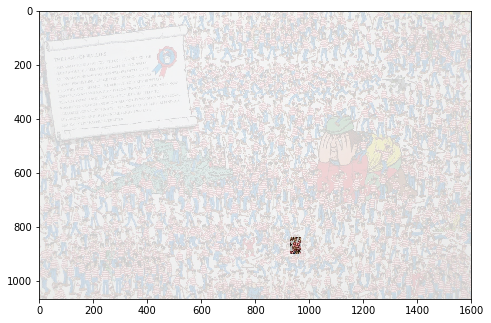

In [0]:
model_path = '/content/gdrive/My Drive/WheresWally/models/research/evall/frozen_inference_graph.pb'

def draw_box(box, image_np):
    #expand the box by 50%
    box += np.array([-(box[2] - box[0])/2, -(box[3] - box[1])/2, (box[2] - box[0])/2, (box[3] - box[1])/2]) 

    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)

    #draw blurred boxes around box
    ax.add_patch(patches.Rectangle((0,0),box[1]*image_np.shape[1], image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))
    ax.add_patch(patches.Rectangle((box[3]*image_np.shape[1],0),image_np.shape[1], image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))
    ax.add_patch(patches.Rectangle((box[1]*image_np.shape[1],0),(box[3]-box[1])*image_np.shape[1], box[0]*image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))
    ax.add_patch(patches.Rectangle((box[1]*image_np.shape[1],box[2]*image_np.shape[0]),(box[3]-box[1])*image_np.shape[1], image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))

    return fig, ax

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    im = Image.open('/content/gdrive/My Drive/WheresWally/eval_images/0.jpg')
    image_np = load_image_into_numpy_array(im)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: np.expand_dims(image_np, axis=0)})

    if scores[0][0] < 0.1:
        sys.exit('Wally not found :(')

    print('Wally found')
    fig, ax = draw_box(boxes[0][0], image_np)
  
    ax.imshow(image_np)
    plt.show()


## 5.2 Ethical Dillemma


When approaching the topic of ethics, it is important to account for all positive and negative impacts on society. The idea of applying object detection in modern society is appealing, as it can be useful in many ways. The most notable application is the application of this technology in the police force. This application would allow for faster reactions to police cases and could possibly prevent incidents before they occur due to early identification of dangerous individuals. However, the accuracy of such a technology has to be infallible. Slight misidentification could lead to major issues developing.

In addition, technology of this caliber could be applied unethically and irresponsibility in ways that often recall the pseudosciences of phrenology and physiognomy. These could affect recognition to hiring, access to insurance, education and policing creates deeply concerning risks at both an individual and societal level. Hence mere public notice of their application in modern society would be insufficient and irresponsible. Communities should be given the right to reject the application of these technologies in both a public and private context. Consent has to seriously considered given the dangers of opressive and continual mass surveillance. 

As such it is important that any application of object detection of individuals or groups be regulated by national laws. This could include strong oversight, clear limitations and public transparency. 



# 6. Conclusion

Our model was successful in locating Wally in even the most confusing of images. While it was able to do so in a short amount of time, the robustness of the detection can be improved. Because the model is trained to locate small Wally's, overfitting would mean that the model will be slow at looking for larger Wally's. To reduce the effect of overfitting, more images of Wally should be used for training. In future iterations of this work, implementing CNNs such as YOLO or Faster-RCNN should yield better results.

##6.1 Future Work

Locating missing people through image analysis:
- Millions of pictures are being uploaded online every day.
- Self-driving cars, which are quickly becoming popular are also using cameras to detect potential obstacles.
- There are also millions of CCTV cameras scattered throughout the world. 
- This should make it possible to locate missing persons autonomously. 
- The main issue would be the complexity of human faces and the lack of consistent training data for each face. 
- Lower resolution images will also result in inaccurate detection.
- Obvious potential ethical issues aside, this could become a powerful tool in reducing the amount of missing people around the world.


Automated CCTV in private properties:
- The main issue in reviewing CCTV footages are the massive amounts of space required to store the video.
- This project could be implemented to store only the data that is required.
- The CCTV will only save recordings when a particular object or person is present. 
- It could also be used to automate the movement of the CCTV.
- Accuracy of object/human detection can be increased through semi supervised learning. 